## Simple Example of PWEM with a band gap
Some notes: We study the TE polarization
step functions (or more accurately box functions) have analytic fourier series coefficients
Look to the overleaf project

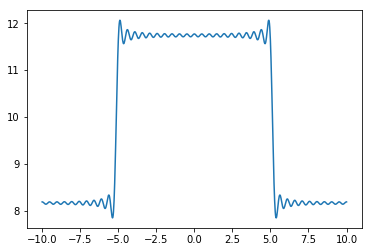

In [277]:
import sys
sys.path.append('D:\\RCWA');
import numpy as np
import matplotlib.pyplot as plt
from convolution_matrices.convmat1D import *

def InvSquareEpsFourier(eg, ed, d, a, Norder):
    ans =  (1/eg-1/ed)*(d/a)*np.sinc(d*np.pi* Norder/ a )+  (Norder == 0 )*1/ed
    return ans;

# YOU CANNOT TAKE
def SquareEpsFourier(eg, ed, d, a, Norder):
    ans =  (eg-ed)*(d/a)*np.sinc(d*np.pi* Norder/ a )+  (Norder == 0 )*ed
    return ans;

def PWEM1D_bragg(num_ord, eg, ed, d,a):
    cx = 0; 
    for m in range(-num_ord, num_ord+1):
        cy =0
        for n in range(-num_ord, num_ord+1):
            nord = m-n
            an = InvSquareEpsFourier(eg, ed, d,a, nord);
            Q[cx, cy] = (2*np.pi*n/a+kz)**2*an;
            cy+=1;
        cx+=1; 
    omegaEigs, modes= np.linalg.eig(Q);
    freqs.append(np.sqrt(omegaEigs))
    return freqs;

d = 8;
a = 10;
eg =1/12.2500; 
ed = 1/1;
x =np.linspace(-a, a, 1000);
Norder = 40;
reconstruction = 0 +0*1j;
for i in range(-Norder,Norder+1):
    reconstruction+=InvSquareEpsFourier(eg, ed, d, a, i)*np.exp(1j*i*np.pi*x/a);

plt.plot(x, reconstruction);
plt.show()


In [278]:
#parameters
d=8; 
a=10; #%total periodicity
d_over_a = d/a;

eg =12.2500; 
ed = 1;

## only need to scan fbz
kz_scan = np.linspace(-2*np.pi/a, 2*np.pi/a, 500)
num_ord = 4;
freqs = [];
Q = np.zeros((2*num_ord+1, 2*num_ord+1));
fourier_coeffs = []

cx = 0; 
for m in range(-2*num_ord, 2*num_ord+1):
    an = InvSquareEpsFourier(eg, ed, d,a, m);
    fourier_coeffs.append(an)
for kz in kz_scan:
    cx = 0; 
    for m in range(-num_ord, num_ord+1):
        cy =0
        for n in range(-num_ord, num_ord+1):
            nord = m-n
            an = InvSquareEpsFourier(eg, ed, d,a, nord);
            Q[cx, cy] = (2*np.pi*n/a+kz)**2*an;
            cy+=1;
        cx+=1; 
    omegaEigs, modes= np.linalg.eig(Q);
    freqs.append(np.sqrt(omegaEigs))
    
freqs_imag = []
Q = np.zeros((2*num_ord+1, 2*num_ord+1));
Q = Q.astype('complex')
for kz in 1j*kz_scan:
    cx = 0; 
    for m in range(-num_ord, num_ord+1):
        cy =0
        for n in range(-num_ord, num_ord+1):
            nord = m-n
            Q[cx, cy] = (2*np.pi*n/a+kz)**2*InvSquareEpsFourier(eg, ed, d,a, nord);
            cy+=1;
        cx+=1; 
    omegaEigs, modes= np.linalg.eig(Q);
    freqs_imag.append(np.sqrt(omegaEigs))
    


(500, 9)
(500,)


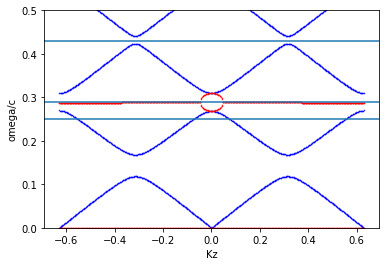

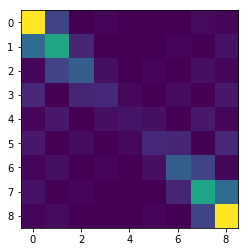

In [279]:
freqs = np.array(freqs);
freqs_imag = np.array(freqs_imag);
print(freqs.shape)
print(kz_scan.shape)
plt.figure()
#plt.plot(kz_scan)
## one of the key problems is that the freqs are not actually ordered by bands... so we'll have to construct a way 
# to filter them out
plt.plot(kz_scan, freqs[:,:], '.b', markersize = 1)    
plt.plot(kz_scan, np.real(freqs_imag), '.r', markersize = 1)    

# for idx in range(length(-pi/a:pi/(10*a):+pi/a))
#     plt.plot(-pi/a:pi/(10*a):+pi/a,freqs(:,idx),'.-')
# end
    
plt.xlabel('Kz')
plt.ylabel('omega/c')
plt.ylim([0,0.5])
plt.axhline(y=0.43)
plt.axhline(y = 0.29)
plt.axhline(y = 0.25)
plt.show()
plt.imshow(np.abs(Q));
plt.show()

C:\Users\zhaon\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in sqrt



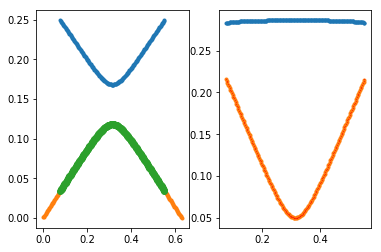

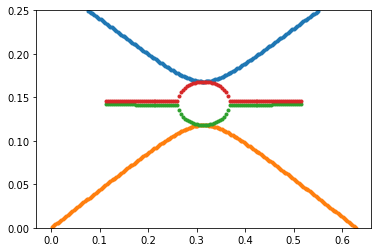

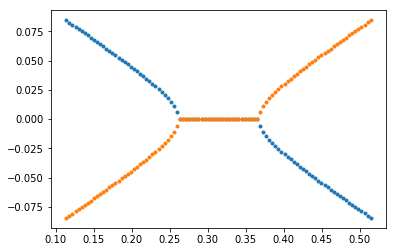

[ 0.28159956 -0.0472577   0.03036573] [ 0.07763246  0.76606546 -0.48100979  0.00372025]


In [291]:
## zip kz, freqs...
from scipy.interpolate import *
from scipy.optimize import curve_fit
def band_filter(freqs, kz_scan, low_w, high_w):
    nw, nm = freqs.shape
    bands = [];
    #we need to pairs the correct kz tooo
    for i in range(nm):
        mfs = freqs[:,i]
        bs = np.stack([kz_scan, mfs], axis = 1);
        bands +=[list(bs[i,:]) for i in range(mfs.shape[0]) if bs[i,1] >= low_w and bs[i,1]<= high_w and bs[i,0]>0]
        #print(bands)
    #bands = np.where(np.logical_and(freqs>=low_w, freqs<=high_w))
    return np.array(bands)
    
upper_bands = band_filter(freqs, kz_scan, 0.15, 0.25)
lower_bands = band_filter(freqs, kz_scan, 0, 0.12)
plt.subplot(121)
plt.plot(upper_bands[:,0], upper_bands[:,1], '.');
plt.plot(lower_bands[:,0], lower_bands[:,1], '.');

## interpolate the bands...
f = interp1d(lower_bands[:,0], lower_bands[:,1]);
interpolated_lower = f(upper_bands[:,0]);
plt.plot(upper_bands[:,0], interpolated_lower, 'o')

## sum and diff
plt.subplot(122)
plt.plot(upper_bands[:,0], interpolated_lower+upper_bands[:,1], '.');
plt.plot(upper_bands[:,0], upper_bands[:,1]-interpolated_lower, '.');

## analytic continuation fit REQUIRES that we consider only a single band, so we have to filter by kz
esum = interpolated_lower+upper_bands[:,1];
ediff =  upper_bands[:,1]-interpolated_lower;
ks = upper_bands[:,0];

## fit a quadratic to sum
z = np.polyfit(ks, esum, 2)
def func0(x, a,b, c):
    return a+b*x**2+c*x;
popt0, pcov0 = curve_fit(func0, ks, esum)
#plt.plot(ks, func0(ks, *popt0), 'r.-')

## fit square root to ediff
def func(x, a, b,c, d):
    f = np.sqrt(a+b*x**2 +c*x)+d; ## adding a fourth order TERM FUCKS THIS UP
    return f;

popt, pcov = curve_fit(func, ks, ediff)
plt.plot(ks, func(ks, *popt), 'r.', markersize = 0.5, linewidth = 0.5)
plt.show()

## analytically continue the fit 
# plt.plot(ks, (func0(ks, *popt0) + func(ks, *popt))/2, 'o')
# plt.plot(ks, (func0(ks, *popt0) - func(ks, *popt))/2, 'o')
plt.plot(upper_bands[:,0], upper_bands[:,1], '.');
plt.plot(lower_bands[:,0], lower_bands[:,1], '.');


# plt.plot(ks, esum, '.')
# plt.plot(ks, ediff, '.')

g1 = np.pi/a;
imk = np.linspace(-0.2, 0.2, 100)
plt.plot(g1+imk, np.real((func0(g1+1j*imk, *popt0)- func(g1+1j*imk, *popt))/2), '.')
plt.plot(g1+imk, np.real((func0(g1+1j*imk, *popt0)+ func(g1+1j*imk, *popt))/2), '.')

#actual data
plt.ylim([0,0.25])
plt.show()

plt.plot(g1+imk, np.imag((func0(g1+1j*imk, *popt0)- func(g1+1j*imk, *popt))/2), '.')
plt.plot(g1+imk, np.imag((func0(g1+1j*imk, *popt0)+ func(g1+1j*imk, *popt))/2), '.')
plt.show()
print(popt0, popt)
# x = np.linspace(-2,2,1000)
# plt.plot(x,x**2+np.sqrt(40+x+x**2))
# plt.plot(x,np.sqrt(40+1j*x+(1j*x)**2))



C:\Users\zhaon\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning:

invalid value encountered in sqrt



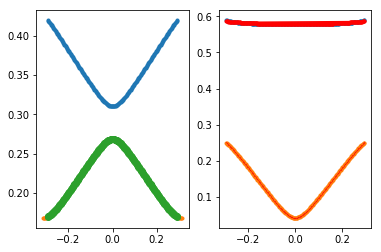

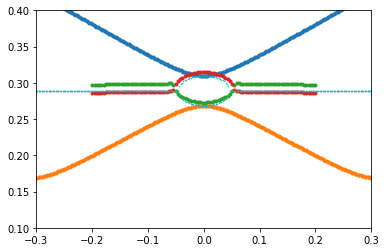

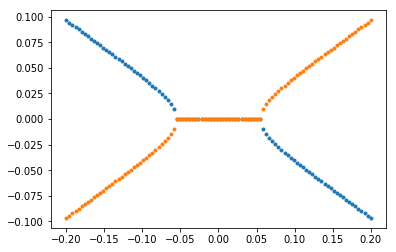

[ 5.77661383e-01  1.00294986e-01 -2.65431397e-09] [ 2.80725351e-03  9.28572086e-01 -1.85629920e+00 -1.10218053e-02
 -6.37812560e-06]


In [293]:
## repeat but with kz = 0
## zip kz, freqs...
from scipy.interpolate import *
from scipy.optimize import curve_fit
def band_filter_z(freqs, kz_scan, low_w, high_w, g1):
    nw, nm = freqs.shape
    bands = [];
    #we need to pairs the correct kz tooo
    for i in range(nm):
        mfs = freqs[:,i]
        bs = np.stack([kz_scan, mfs], axis = 1);
        bands +=[list(bs[i,:]) for i in range(mfs.shape[0]) if bs[i,1] >= low_w and bs[i,1]<= high_w and bs[i,0]>-g1 and bs[i,0] <g1]
        #print(bands)
    #bands = np.where(np.logical_and(freqs>=low_w, freqs<=high_w))
    return np.array(bands)
    
g1 = np.pi/a;
upper_bands = band_filter_z(freqs, kz_scan, 0.29, 0.42, g1) ## sensitivity to other edges so keep it local
lower_bands = band_filter_z(freqs, kz_scan, 0.15, 0.29, g1)
plt.subplot(121)
plt.plot(upper_bands[:,0], upper_bands[:,1], '.');
plt.plot(lower_bands[:,0], lower_bands[:,1], '.');

## interpolate the bands...
f = interp1d(lower_bands[:,0], lower_bands[:,1]);
interpolated_lower = f(upper_bands[:,0]);
plt.plot(upper_bands[:,0], interpolated_lower, 'o')

## sum and diff
plt.subplot(122)
plt.plot(upper_bands[:,0], interpolated_lower+upper_bands[:,1], '.');
plt.plot(upper_bands[:,0], upper_bands[:,1]-interpolated_lower, '.');

## analytic continuation fit REQUIRES that we consider only a single band, so we have to filter by kz
esum = interpolated_lower+upper_bands[:,1];
ediff =  upper_bands[:,1]-interpolated_lower;
ks = upper_bands[:,0];

## fit a quadratic to sum
z = np.polyfit(ks, esum, 2)
def func0(x, a,b, c):
    return a+b*x**2+c*x;
popt0, pcov0 = curve_fit(func0, ks, esum)
plt.plot(ks, func0(ks, *popt0), 'r.-')

## fit square root to ediff
def func(x, a, b,c, d,e):
    f = np.sqrt(a+b*x**2 +c*x**4 +e*x**3)+d; ## adding a fourth order TERM FUCKS THIS UP
    return f;

popt, pcov = curve_fit(func, ks, ediff)
plt.plot(ks, func(ks, *popt), 'r.', markersize = 0.5, linewidth = 0.5)
plt.show()

## analytically continue the fit 
# plt.plot(ks, (func0(ks, *popt0) + func(ks, *popt))/2, 'o')
# plt.plot(ks, (func0(ks, *popt0) - func(ks, *popt))/2, 'o')
plt.plot(upper_bands[:,0], upper_bands[:,1], '.');
plt.plot(lower_bands[:,0], lower_bands[:,1], '.');


# plt.plot(ks, esum, '.')
# plt.plot(ks, ediff, '.')

gc= 0
imk = np.linspace(-0.2, 0.2, 100)
plt.plot(gc+imk, np.real((func0(g1+1j*imk, *popt0)- func(gc+1j*imk, *popt))/2), '.')
plt.plot(gc+imk, np.real((func0(g1+1j*imk, *popt0)+ func(gc+1j*imk, *popt))/2), '.')
plt.plot(kz_scan, np.real(freqs_imag), '.c', markersize = 1)    
plt.ylim([0.1,0.4])
plt.xlim([-0.3, 0.3])
#actual data
plt.show()

plt.plot(gc+imk, np.imag((func0(gc+1j*imk, *popt0)- func(gc+1j*imk, *popt))/2), '.')
plt.plot(gc+imk, np.imag((func0(gc+1j*imk, *popt0)+ func(gc+1j*imk, *popt))/2), '.')

plt.show()
print(popt0, popt)
# x = np.linspace(-2,2,1000)
# plt.plot(x,x**2+np.sqrt(40+x+x**2))
# plt.plot(x,np.sqrt(40+1j*x+(1j*x)**2))



## formulation with convolution matrix
This will allow us to see if we can invert the convolution of the sine series to get the answer

According to PWEM, a sine grating only has one band gap? That seems wrong.

(17,)


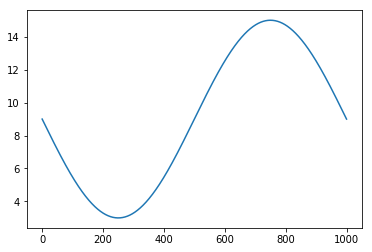

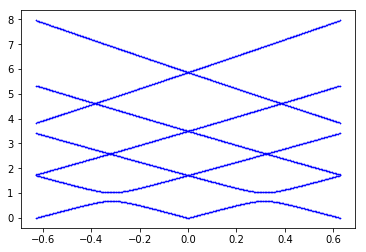

In [283]:
def convmat1D(A,P):
    N = A.shape;
    NH = P;
    p = list(range(-int(np.floor(P / 2)), int(np.floor(P / 2)) + 1));
    Af = (1 / np.prod(N)) * np.fft.fftshift(np.fft.fftn(A));
    # central indices;
    p0 = int(np.floor(N[0] / 2));
    C = np.zeros((NH, NH))
    C = C.astype(complex);
    for prow in range(P):
        # first term locates z plane, 2nd locates y column, prow locates x
        for pcol in range(P):
            pfft = p[prow] - p[pcol];
            C[prow, pcol] = Af[p0 +pfft];
    return C;

## Formulating using matrices
fourier_coeffs = np.array(fourier_coeffs)
print(fourier_coeffs.shape)
A = np.ones(1000,)

## for metallic cases, the two formalisms do not agree at present.
x = np.linspace(-a/2, a/2, 1000);
A = 9+6*np.sin(2*np.pi*x/a);
# A[200:800] = 1/12.
25;
A2 = np.ones(1000,);A2[200:800] = 12.25;
num_ord = 3

CN = convmat1D(A, 2*num_ord+1)
CN2 = convmat1D(A2, 2*num_ord+1);
plt.plot(A);
plt.show();
freqs_numeric = [];
for kz in kz_scan:
    nscan = np.arange(-num_ord, num_ord+1)
    #print(len(nscan))
    KZ = np.diag((2*np.pi*nscan/a+kz)**2)
    #Q = np.linalg.inv(CN2)@KZ;
    Q = KZ@CN; ## order is important... if we use inverse...
    Q = Q.astype('complex')
    omegaEigs, modes= np.linalg.eig(Q);
    freqs_numeric.append(np.sqrt(omegaEigs))    
plt.plot(kz_scan, freqs_numeric, '.b', markersize = 1) 
#plt.plot(kz_scan, np.imag(freqs_numeric), '.r', markersize = 1)
#plt.plot(kz_scan, freqs, '.g', markersize = 1)    
#plt.ylim([0,0.4])
plt.show()
 

## A priori, is anything from lifeng li's paper relevant here?
We can get any real positive dielectric to agree between the two formalisms, but once the dielectric constant is negative,
then we get into some hairy problems.


In [284]:
## a priori, we cannot actually determine the complex band structure
# what we need is

## scan of all complex space

Strictly speaking, this does not make sense to me because technically, you're dealing with a complex input into the series with a complex output. The complex output is fine as I could just use a metallic dielectric, but the complex input, not so much.

In [285]:
num_ord = 1;
CN = convmat1D(A, 2*num_ord+1)
CN2 = convmat1D(A2, 2*num_ord+1);
Nr = 100; Ni = 100
real_scan = np.linspace(-2*np.pi/a, 2*np.pi/a, Nr)
imag_scan = -1j*np.linspace(-2*np.pi/a, 2*np.pi/a, Ni)
freq_map = np.zeros((Nr,Ni, 2*num_ord+1));
freq_map = freq_map.astype('complex')
for r in range(len(real_scan)):
    for i in range(len(imag_scan)):
        real = real_scan[r];
        imag = imag_scan[i];
        kz = real+imag;
        nscan = np.arange(-num_ord, num_ord+1)
        #print(len(nscan))
        KZ = np.diag((2*np.pi*nscan/a+kz)**2)
        Q = CN@KZ;
        Q = Q.astype('complex')
        omegaEigs, modes= np.linalg.eig(Q);
        freq_map[r,i,:]=(np.sqrt(omegaEigs))        

In [286]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import plotly.plotly as py
import plotly.graph_objs as go

In [287]:
Rk, Ik = np.meshgrid(real_scan, imag_scan);

trace1 = go.Scatter3d(
    x=Rk.flatten(),
    y=np.imag(Ik).flatten(),
    z=np.real(freq_map[:,:,1].flatten()),
    mode='markers',
    marker=dict(
        size=6,
        color='blue',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)
trace2 = go.Scatter3d(
    x=Rk.flatten(),
    y=np.imag(Ik).flatten(),
    z=np.real(freq_map[:,:,0].flatten()),
    mode='markers',
    marker=dict(
        size=6,
        color='green',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1, trace2]
layout = go.Layout(
 scene = dict(
                    xaxis = dict(
                        title='re(k)'),
                    yaxis = dict(
                        title='Im(k)'),
                    zaxis = dict(
                        title='freq'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pwem_3d_surface')


C:\Users\zhaon\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [288]:
print(freq_map.shape)

(100, 100, 3)


In [289]:
Rk, Ik = np.meshgrid(real_scan, imag_scan);

trace1 = go.Scatter3d(
    x=Rk.flatten(),
    y=np.imag(Ik).flatten(),
    z=np.imag(freq_map[:,:,2].flatten()),
    mode='markers',
    marker=dict(
        size=6,
        color='red',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)
trace2 = go.Scatter3d(
    x=Rk.flatten(),
    y=np.imag(Ik).flatten(),
    z=np.imag(freq_map[:,:,0].flatten()),
    mode='markers',
    marker=dict(
        size=6,
        color='red',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
 scene = dict(
                    xaxis = dict(
                        title='re(k)'),
                    yaxis = dict(
                        title='Im(k)'),
                    zaxis = dict(
                        title='freq'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)
